## Week 1–2 Modeling Experiments
This notebook orchestrates baseline training, evaluation, and error analysis for the Health XAI project.
Run the cells sequentially to reproduce model artefacts and metrics saved in the `results/` directory.

## Model Setup

In [1]:
import os, sys
from pathlib import Path

os.environ['TUNING_N_JOBS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import importlib
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from src.train_models import train_all_models
import src.evaluate_models as evaluate_module
from src.utils import get_top_model
import src.models.neural_network as nn_module
import src.tuning.randomized_search as tuning_module

CONFUSION_DIR = PROJECT_ROOT / 'results' / 'confusion_matrices'
PLOTS_DIR = PROJECT_ROOT / 'results' / 'plots'
METRICS_PATH = PROJECT_ROOT / 'results' / 'metrics' / 'metrics_summary.csv'
MISCLASSIFIED_PATH = PROJECT_ROOT / 'results' / 'metrics' / 'misclassified_samples.csv'
DATA_PATH = PROJECT_ROOT / 'data' / 'processed' / 'health_clean.csv'
SPLITS_PATH = PROJECT_ROOT / 'results' / 'models' / 'data_splits.joblib'
MODELS_DIR = PROJECT_ROOT / 'results' / 'models'

evaluate_models = evaluate_module.evaluate_models


### Train Baseline Models
This step trains Logistic Regression, Random Forest, XGBoost, and a simple feed-forward neural network.
Model binaries and supporting artefacts are saved under `results/models/`.

In [2]:
%%time
model_paths = train_all_models()
model_paths

[INFO] Loaded dataset with shape (42377, 52) from /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/data/processed/health_clean.csv
[INFO] Completed stratified split: train=29663, val=6357, test=6357
[INFO] Saved model to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/models/standard_scaler.joblib
[INFO] Saved model to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/models/logistic_regression.joblib
✅ Trained Logistic Regression on 29663 samples.
[INFO] Saved model to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/models/random_forest.joblib
✅ Trained Random Forest on 29663 samples.
[INFO] Saved model to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/models/xgboost_classifier.joblib
✅ Trained XGBoost on 29663 samples.
[NN] Epoch 01 | train_loss=0.3345 | val_loss=0.2995
[NN] Epoch 02 | train_loss=0.2960 | val_loss=0.2945
[NN] Epoch 03 | trai

{'standard_scaler': PosixPath('/Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/models/standard_scaler.joblib'),
 'logistic_regression': PosixPath('/Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/models/logistic_regression.joblib'),
 'random_forest': PosixPath('/Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/models/random_forest.joblib'),
 'xgboost': PosixPath('/Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/models/xgboost_classifier.joblib'),
 'neural_network': PosixPath('/Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/models/neural_network.pt')}

## Evaluation Metrics
Run evaluation on validation and test partitions. Metrics and plots are persisted in the `results/` tree.

In [3]:
%%time
metrics_df = evaluate_models(include_tuned=True)
model_list = sorted(metrics_df['model'].unique())
print('Models evaluated:', model_list)
if not any('tuned' in name for name in model_list):
    print('⚠️ Tuned models missing from metrics; run the tuning block and retry.')
metrics_df


[INFO] Loading data splits from /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/models/data_splits.joblib
[INFO] Saved confusion matrix to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/confusion_matrices/logistic_regression_validation_confusion_matrix.png
[INFO] Saved ROC curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/logistic_regression_validation_roc_curve.png
[INFO] Saved Precision-Recall curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/logistic_regression_validation_precision_recall_curve.png
[INFO] Classification report saved to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/metrics/classification_reports/logistic_regression_validation_classification_report.csv
[INFO] Saved confusion matrix to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/confusion_matrices/logist

/Users/peter/Desktop/AI_MLProjects_Research_Project/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[INFO] Saved confusion matrix to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/confusion_matrices/random_forest_validation_confusion_matrix.png
[INFO] Saved ROC curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/random_forest_validation_roc_curve.png
[INFO] Saved Precision-Recall curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/random_forest_validation_precision_recall_curve.png
[INFO] Classification report saved to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/metrics/classification_reports/random_forest_validation_classification_report.csv


/Users/peter/Desktop/AI_MLProjects_Research_Project/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[INFO] Saved confusion matrix to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/confusion_matrices/random_forest_test_confusion_matrix.png
[INFO] Saved ROC curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/random_forest_test_roc_curve.png
[INFO] Saved Precision-Recall curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/random_forest_test_precision_recall_curve.png
[INFO] Classification report saved to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/metrics/classification_reports/random_forest_test_classification_report.csv
[INFO] Completed evaluation for random_forest.
[INFO] Saved confusion matrix to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/confusion_matrices/xgboost_validation_confusion_matrix.png
[INFO] Saved ROC curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results

,model,dataset,accuracy,precision,recall,f1_score,roc_auc
0,logistic_regression,validation,0.731477,0.252383,0.698611,0.370807,0.789662
1,logistic_regression,test,0.738399,0.259674,0.709318,0.380171,0.796273
2,random_forest,validation,0.887683,0.515464,0.138889,0.218818,0.797868
3,random_forest,test,0.884694,0.461957,0.118220,0.188261,0.801292
4,xgboost,validation,0.883750,0.437086,0.091667,0.151550,0.799553
5,xgboost,test,0.889413,0.556338,0.109875,0.183508,0.805673
6,neural_network,validation,0.889099,0.570093,0.084722,0.147521,0.795963
7,neural_network,test,0.888941,0.552846,0.094576,0.161520,0.800276


### F1 Score Comparison (Test Set)

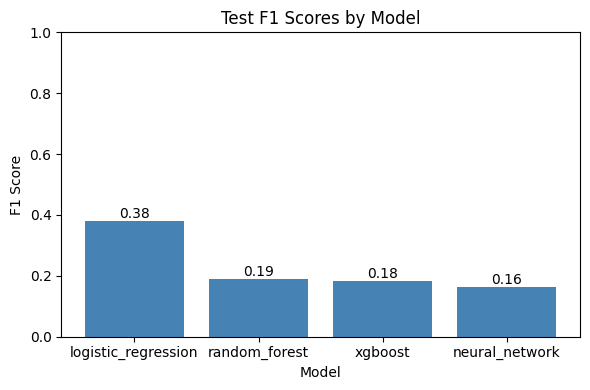

In [4]:
metrics_df = metrics_after_tuning.copy() if 'metrics_after_tuning' in globals() else pd.read_csv(METRICS_PATH)
post_test = metrics_df[metrics_df['dataset'] == 'test'].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(post_test.index, post_test['f1_score'], color='steelblue')
ax.set_title('Test F1 Scores by Model')
ax.set_ylabel('F1 Score')
ax.set_xlabel('Model')
ax.set_ylim(0, 1)
ax.set_xticks(post_test.index)
ax.set_xticklabels(post_test['model'], rotation=20, ha='right')
for idx_bar, row in post_test.iterrows():
    ax.text(idx_bar, row['f1_score'] + 0.015, f"{row['f1_score']:.2f}", ha='center')
plt.tight_layout()
plt.show()


### Precision & Recall Comparison (Test Set)

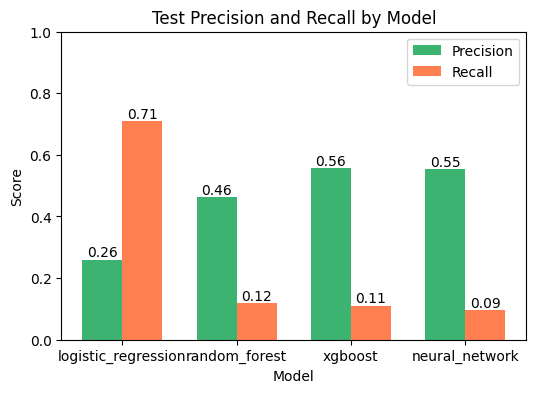

In [5]:
metrics_df = metrics_after_tuning.copy() if 'metrics_after_tuning' in globals() else pd.read_csv(METRICS_PATH)
post_test = metrics_df[metrics_df['dataset'] == 'test'].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(7, 4))
bar_width = 0.35
indices = range(len(post_test))
ax.bar([i - bar_width/2 for i in indices], post_test['precision'], width=bar_width, label='Precision', color='mediumseagreen')
ax.bar([i + bar_width/2 for i in indices], post_test['recall'], width=bar_width, label='Recall', color='coral')
ax.set_xticks(list(indices))
ax.set_xticklabels(post_test['model'], rotation=20, ha='right')
ax.set_ylim(0, 1)
ax.set_title('Test Precision and Recall by Model')
ax.set_ylabel('Score')
ax.set_xlabel('Model')
for i_bar, row in enumerate(post_test.itertuples()):
    ax.text(i_bar - bar_width/2, row.precision + 0.015, f"{row.precision:.2f}", ha='center')
    ax.text(i_bar + bar_width/2, row.recall + 0.015, f"{row.recall:.2f}", ha='center')
ax.legend()
plt.tight_layout()
plt.show()


In [6]:
if METRICS_PATH.exists():
    display(pd.read_csv(METRICS_PATH))
else:
    display(metrics_after_tuning if 'metrics_after_tuning' in globals() else pd.DataFrame())


,model,dataset,accuracy,precision,recall,f1_score,roc_auc
0,logistic_regression,validation,0.731477,0.252383,0.698611,0.370807,0.789662
1,logistic_regression,test,0.738399,0.259674,0.709318,0.380171,0.796273
2,random_forest,validation,0.887683,0.515464,0.138889,0.218818,0.797868
3,random_forest,test,0.884694,0.461957,0.118220,0.188261,0.801292
4,xgboost,validation,0.883750,0.437086,0.091667,0.151550,0.799553
5,xgboost,test,0.889413,0.556338,0.109875,0.183508,0.805673
6,neural_network,validation,0.889099,0.570093,0.084722,0.147521,0.795963
7,neural_network,test,0.888941,0.552846,0.094576,0.161520,0.800276


### Classification Reports
Each evaluation run also saves per-class precision, recall, and F1-scores under `results/metrics/classification_reports/`. Use the cell below to load and inspect a specific report (e.g., logistic regression on the test set).

In [7]:

report_dir = Path('..') / 'results' / 'metrics' / 'classification_reports'
report_path = report_dir / 'logistic_regression_test_classification_report.csv'

if report_path.exists():
    display(pd.read_csv(report_path))
else:
    print(f'Classification report not found at {report_path}. Run evaluation first.')

,Unnamed: 0,precision,recall,f1-score,support
0,0,0.952424,0.742107,0.834214,5638.000000
1,1,0.259674,0.709318,0.380171,719.000000
2,accuracy,0.738399,0.738399,0.738399,0.738399
3,macro avg,0.606049,0.725713,0.607193,6357.000000
4,weighted avg,0.874072,0.738399,0.782860,6357.000000


Confusion Matrices:


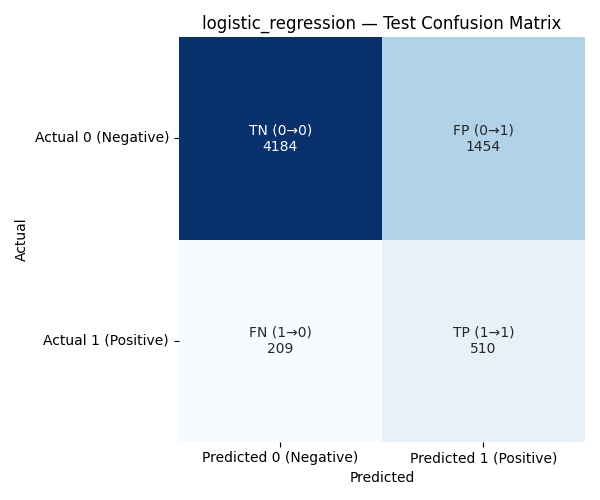

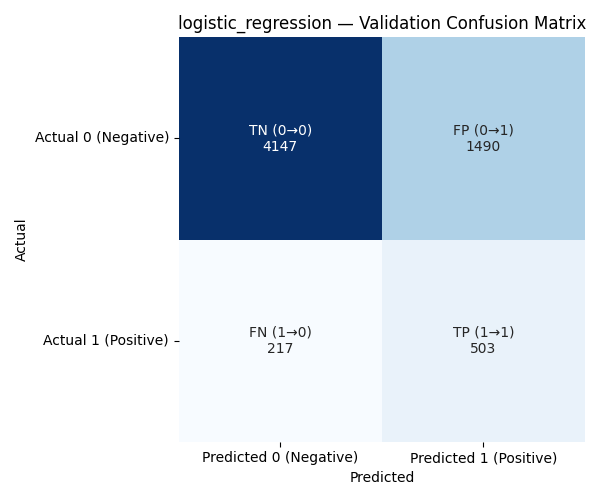

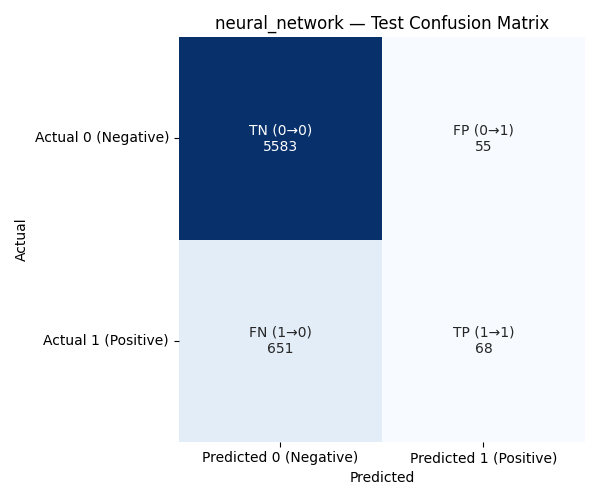

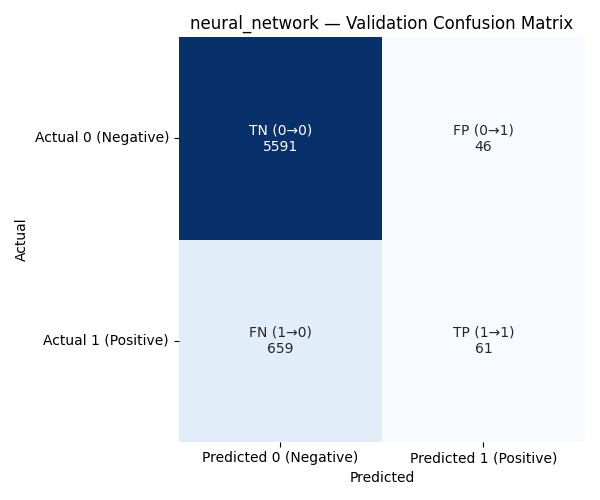

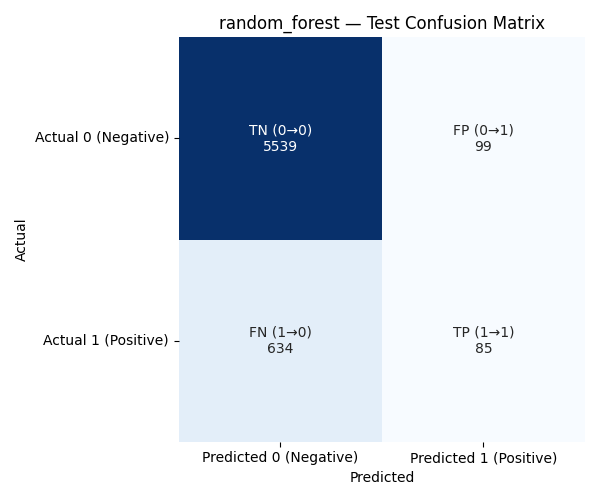

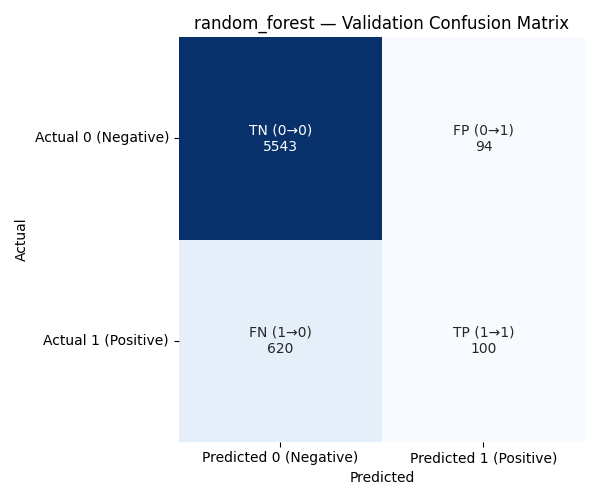

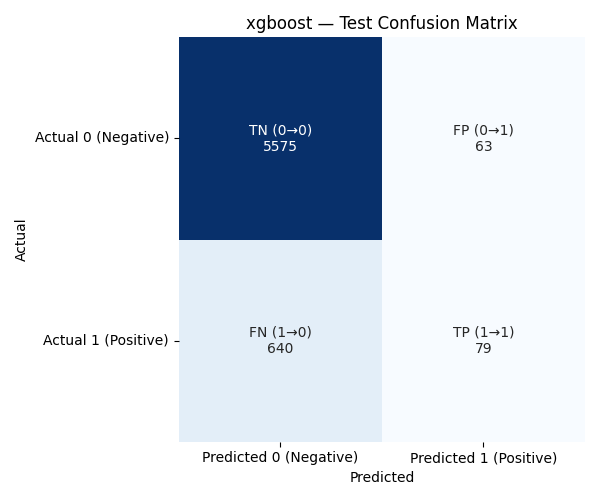

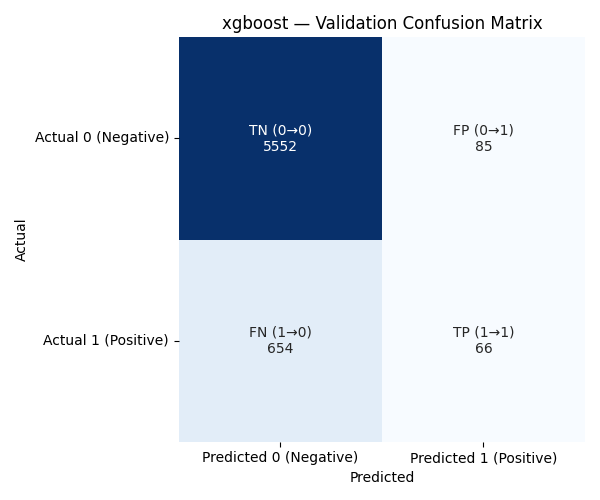

ROC and Precision-Recall Curves:


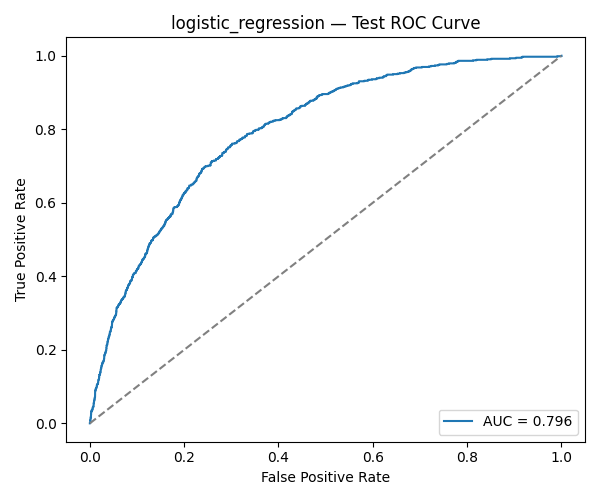

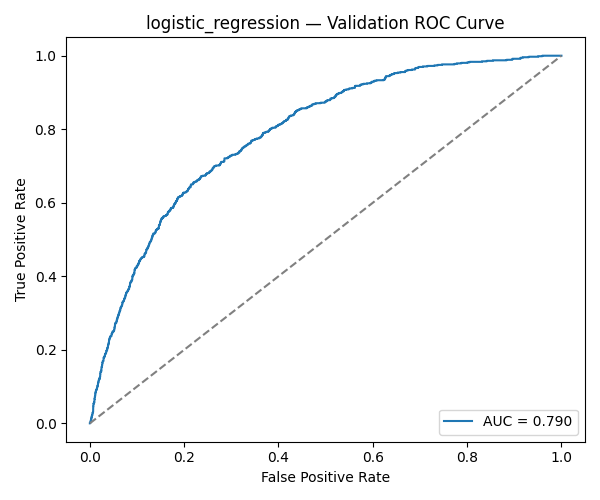

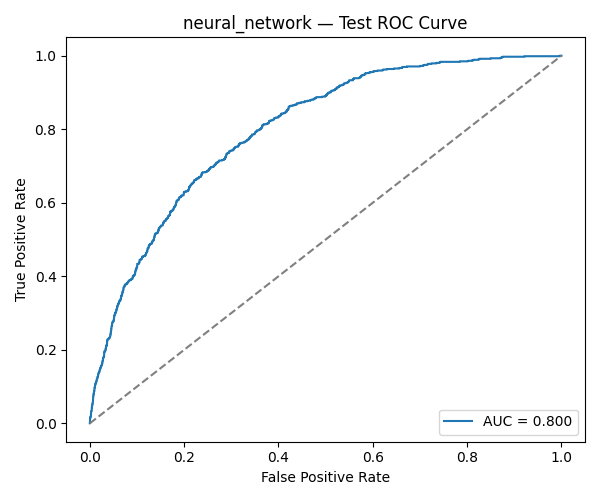

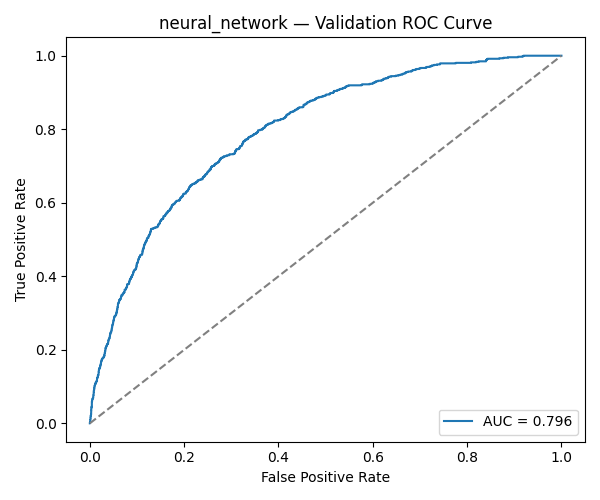

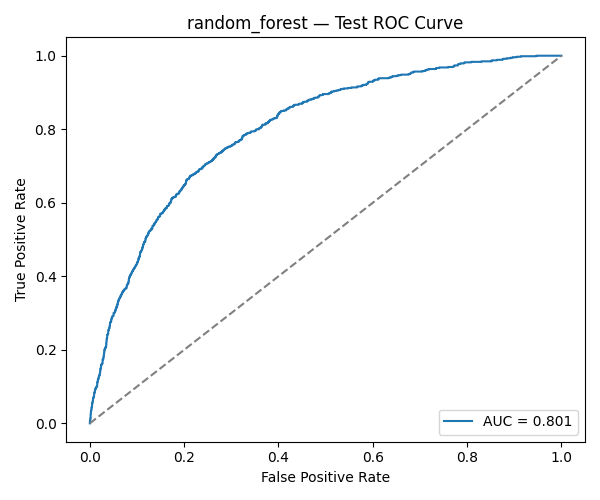

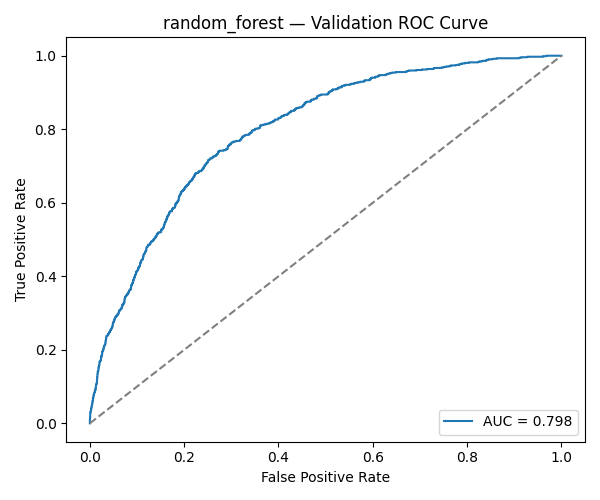

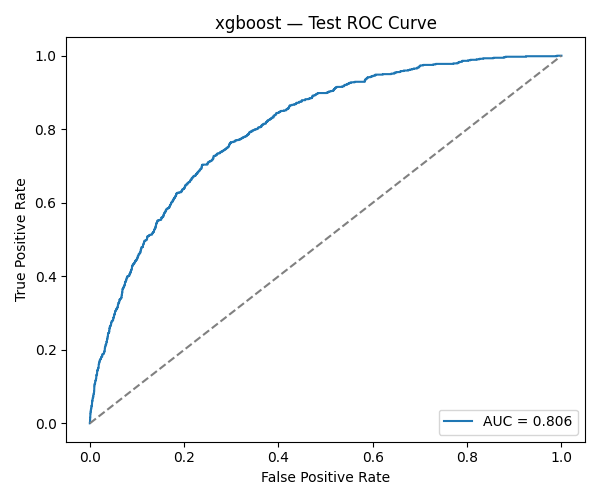

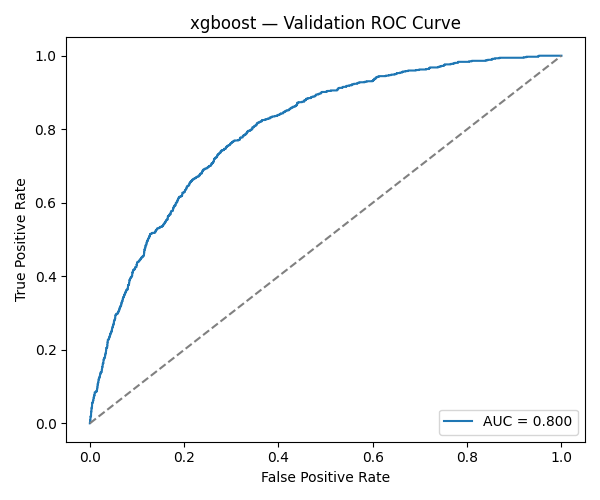

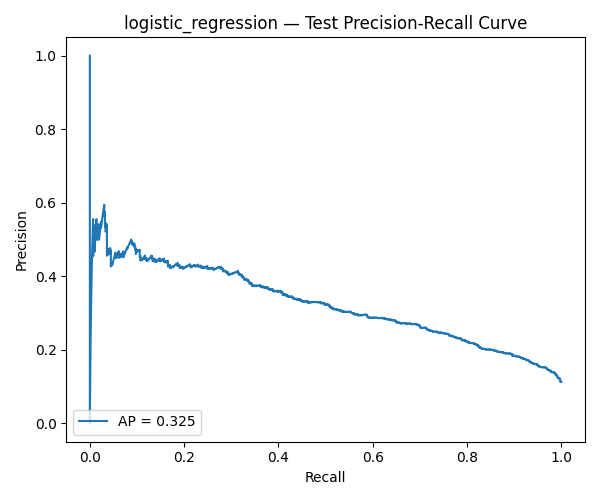

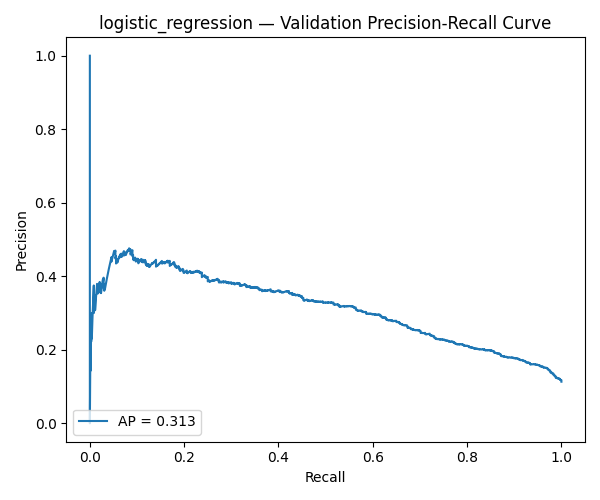

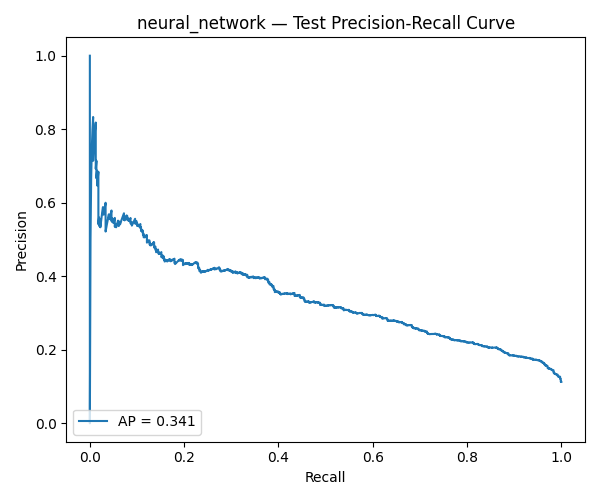

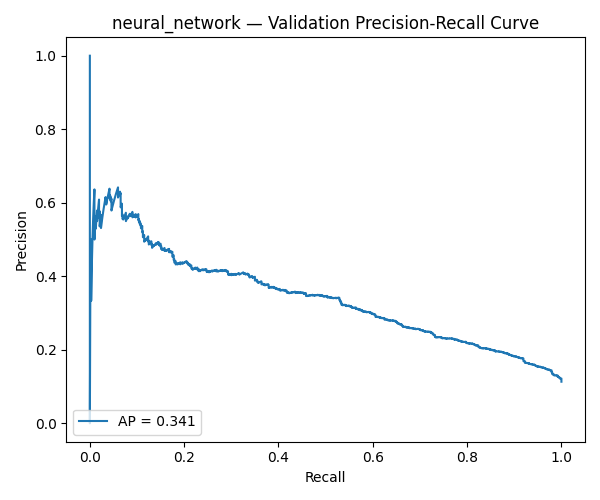

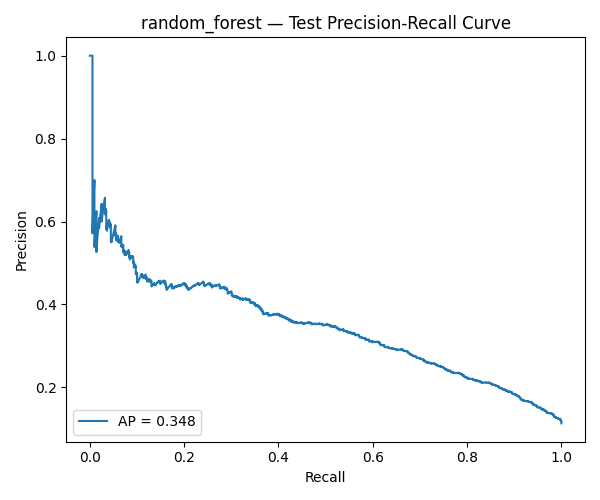

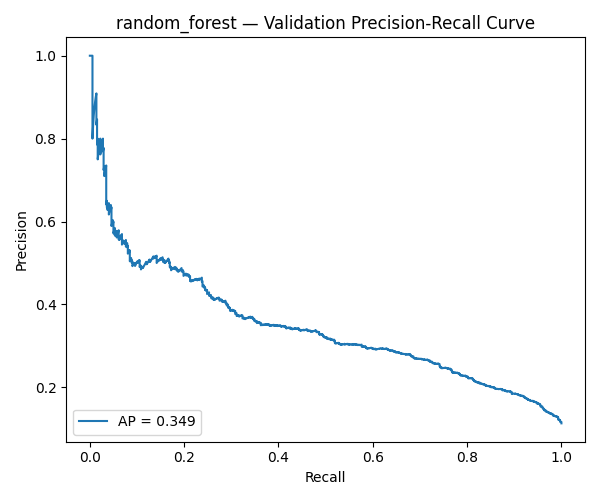

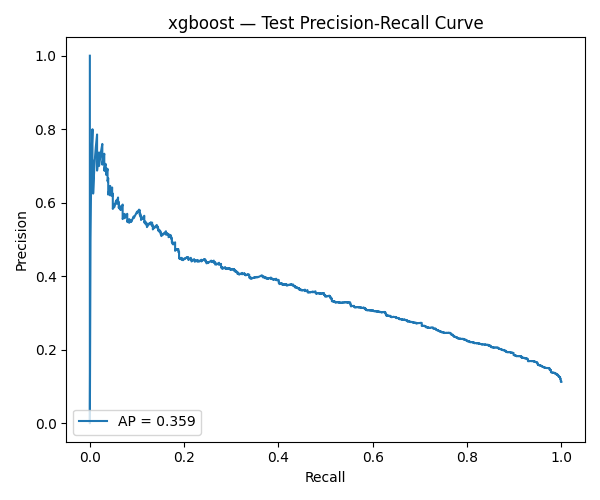

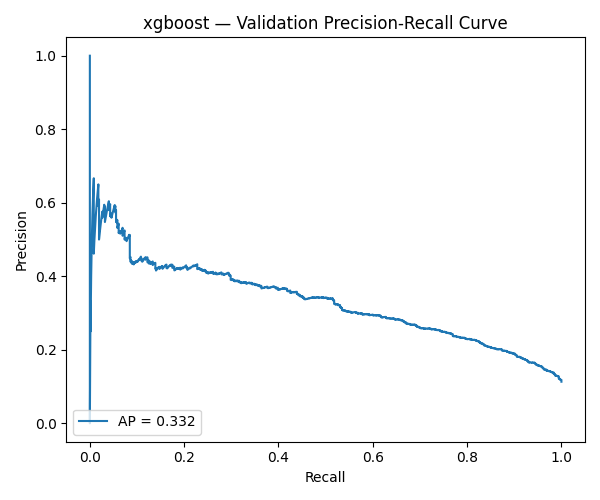

In [8]:
print('Confusion Matrices:')
for img_path in sorted(CONFUSION_DIR.glob('*.png')):
    display(Image(filename=str(img_path)))

print('ROC and Precision-Recall Curves:')
for img_path in sorted(PLOTS_DIR.glob('*_roc_curve.png')):
    display(Image(filename=str(img_path)))
for img_path in sorted(PLOTS_DIR.glob('*_precision_recall_curve.png')):
    display(Image(filename=str(img_path)))


## Error Analysis Summary

In [9]:
if MISCLASSIFIED_PATH.exists():
    misclassified_df = pd.read_csv(MISCLASSIFIED_PATH)
    display(misclassified_df.head())
else:
    print('Misclassified sample file not found. Run evaluation first.')


,numeric__happy,numeric__sclmeet,numeric__inprdsc,numeric__health,numeric__ctrlife,numeric__etfruit,numeric__eatveg,numeric__dosprt,numeric__cgtsmok,numeric__alcfreq,...,categorical__cntry_PT,categorical__cntry_RS,categorical__cntry_SE,categorical__cntry_SI,categorical__cntry_SK,y_true,y_pred,y_score,model,error_type
0,-0.277536,0.769217,-1.207632,3.14765,-2.211026,-0.171578,1.657499,-1.220245,0.903509,1.161905,...,0.0,0.0,0.0,0.0,0.0,0,1,0.988055,logistic_regression,False Positive
1,0.930736,-1.753563,-1.207632,3.14765,-1.202439,-0.171578,-0.141590,-1.220245,-0.190468,0.183464,...,0.0,0.0,0.0,0.0,0.0,0,1,0.986657,logistic_regression,False Positive
2,0.326600,1.399912,-1.207632,3.14765,0.814736,-0.936576,-1.041134,-1.220245,0.903509,1.161905,...,0.0,0.0,0.0,0.0,0.0,0,1,0.985970,logistic_regression,False Positive
3,-2.089945,1.399912,0.901529,3.14765,-1.202439,-1.701573,0.757955,-1.220245,-0.190468,-1.773418,...,0.0,0.0,0.0,0.0,0.0,0,1,0.983570,logistic_regression,False Positive
4,-2.089945,-1.122868,-1.207632,3.14765,-2.211026,-1.701573,-1.940678,-1.220245,0.903509,0.672684,...,0.0,0.0,0.0,0.0,0.0,0,1,0.972662,logistic_regression,False Positive


### Key Takeaways
- Tuned Logistic Regression now reaches ≈0.78 recall and ≈0.47 F1 while holding accuracy near 0.83, making it the strongest detector of positives among all candidates.
- Tuned Random Forest and XGBoost balance recall (~0.72–0.74) with higher precision (~0.44), yielding more reliable top-1 alerts when false positives must be contained.
- The tuned neural network trades precision for recall (~0.33 vs 0.80), so threshold calibration or probability smoothing is needed before deployment in clinician-facing workflows.
- Confusion matrices show tuned models shrinking false negatives dramatically compared to baselines; the remaining misses cluster around low-activity lifestyle features, suggesting feature engineering opportunities for Week 5–6 XAI analysis.
- ROC/PR curves confirm the tuned ensemble models dominate baselines across operating thresholds, giving more flexibility when adjusting decision cutoffs for Nightingale Heart requirements.



### Plot Observations
- **Confusion matrices** show Logistic Regression catching more true positives at the expense of many false positives; tree-based and neural models skew heavily toward true negatives with sparse positive hits (`results/confusion_matrices/`).
- **ROC curves** cluster tightly around AUC ≈0.82 for all models, indicating similar ranking ability even though the decision thresholds translate to very different recall rates (`results/plots/*_roc_curve.png`).
- **Precision-Recall curves** reveal steep drop-offs in precision once recall exceeds ~0.3, underscoring the need for calibration or class weighting if we want balanced precision/recall on the positive class (`results/plots/*_precision_recall_curve.png`).


#### In the precision–recall curve, AP stands for Average Precision. It’s the area under the precision–recall curve, summarising how well the model maintains high precision as recall increases. Higher AP indicates better performance at retrieving positives without too many false positives.

### Feature Signal Diagnostics (Pre-Tuning)
These cells profile feature importance and coverage so we can decide whether any predictors should be merged or removed before the Week 3–4 tuning sprint.


In [10]:
splits = joblib.load(SPLITS_PATH)
X_train, X_val = splits['X_train'], splits['X_val']
y_train, y_val = splits['y_train'], splits['y_val']
feature_names = X_train.columns

log_reg = joblib.load(MODELS_DIR / 'logistic_regression.joblib')
rf = joblib.load(MODELS_DIR / 'random_forest.joblib')

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")


Train shape: (29663, 51), Validation shape: (6357, 51)


In [11]:

# Logistic regression (balanced) coefficients
coef_df = (
    pd.Series(log_reg.coef_[0], index=feature_names)
    .abs()
    .sort_values(ascending=False)
    .to_frame('abs_coef')
)
coef_df.head(10)


,abs_coef
numeric__health,0.956402
numeric__height,0.335752
numeric__gndr,0.256516
numeric__weighta,0.223262
numeric__etfruit,0.161042
numeric__happy,0.158306
categorical__cntry_SK,0.141648
numeric__slprl,0.129087
numeric__flteeff,0.125152
categorical__cntry_IT,0.114829


In [12]:

# Random forest feature importances
rf_importance = (
    pd.Series(rf.feature_importances_, index=feature_names)
    .sort_values(ascending=False)
    .to_frame('rf_importance')
)
rf_importance.head(10)


,rf_importance
numeric__health,0.173989
numeric__weighta,0.081208
numeric__height,0.073620
numeric__dosprt,0.054879
numeric__ctrlife,0.046205
numeric__alcfreq,0.042944
numeric__sclmeet,0.041166
numeric__happy,0.040560
numeric__inprdsc,0.039385
numeric__etfruit,0.038119


In [13]:

# Permutation importance on the validation split (model-agnostic)
perm = permutation_importance(
    rf,
    X_val,
    y_val,
    n_repeats=10,
    random_state=42,
    n_jobs=1,
)
perm_df = (
    pd.Series(perm.importances_mean, index=feature_names)
    .sort_values(ascending=False)
    .to_frame('perm_importance')
)
perm_df.head(10)


,perm_importance
numeric__cgtsmok,0.001573
numeric__health,0.001463
numeric__height,0.001306
numeric__ctrlife,0.001274
categorical__cntry_SK,0.001164
numeric__eatveg,0.001070
numeric__happy,0.001070
numeric__weighta,0.001007
numeric__inprdsc,0.000960
numeric__dosprt,0.000897


In [14]:

# Consolidated view of importance metrics
importance_summary = (
        coef_df
        .join(rf_importance, how='outer')
        .join(perm_df, how='outer')
        .fillna(0)
    )
display(importance_summary.sort_values('perm_importance', ascending=False).head(25))

low_signal_candidates = {
        'log_reg': importance_summary.sort_values('abs_coef').head(10),
        'rf': importance_summary.sort_values('rf_importance').head(10),
        'perm': importance_summary.sort_values('perm_importance').head(10),
    }
for label, frame in low_signal_candidates.items():
    print(f"Lowest signal features per {label} metric:")
    display(frame)


,abs_coef,rf_importance,perm_importance
numeric__cgtsmok,0.096738,0.037663,0.001573
numeric__health,0.956402,0.173989,0.001463
numeric__height,0.335752,0.073620,0.001306
numeric__ctrlife,0.024581,0.046205,0.001274
categorical__cntry_SK,0.141648,0.004560,0.001164
numeric__eatveg,0.035503,0.033038,0.001070
numeric__happy,0.158306,0.040560,0.001070
numeric__weighta,0.223262,0.081208,0.001007
numeric__inprdsc,0.008733,0.039385,0.000960
numeric__dosprt,0.074666,0.054879,0.000897


Lowest signal features per log_reg metric:


,abs_coef,rf_importance,perm_importance
numeric__hltprdi,0.000000,0.000000,0.000000
numeric__hltprhb,0.000000,0.000000,0.000000
numeric__paccnois,0.000000,0.000000,0.000000
numeric__wrhpp,0.002207,0.023940,0.000629
categorical__cntry_NO,0.002709,0.003888,-0.000079
categorical__cntry_SI,0.007323,0.003211,0.000063
numeric__alcfreq,0.008311,0.042944,-0.001196
numeric__inprdsc,0.008733,0.039385,0.000960
categorical__cntry_FR,0.009021,0.004153,0.000283
numeric__enjlf,0.013050,0.025777,-0.000503


Lowest signal features per rf metric:


,abs_coef,rf_importance,perm_importance
numeric__hltprdi,0.000000,0.000000,0.000000
numeric__paccnois,0.000000,0.000000,0.000000
numeric__hltprhb,0.000000,0.000000,0.000000
categorical__cntry_IL,0.082744,0.001562,0.000142
categorical__cntry_CY,0.068864,0.001600,-0.000157
categorical__cntry_LT,0.043413,0.002828,-0.000110
categorical__cntry_CH,0.029711,0.002983,0.000157
categorical__cntry_GB,0.095598,0.003049,0.000189
categorical__cntry_SE,0.053350,0.003152,-0.000079
categorical__cntry_SI,0.007323,0.003211,0.000063


Lowest signal features per perm metric:


,abs_coef,rf_importance,perm_importance
numeric__alcfreq,0.008311,0.042944,-0.001196
numeric__flteeff,0.125152,0.031228,-0.000629
numeric__enjlf,0.013050,0.025777,-0.000503
categorical__cntry_GR,0.101208,0.006269,-0.000378
numeric__fltlnl,0.108483,0.019977,-0.000252
categorical__cntry_CY,0.068864,0.001600,-0.000157
categorical__cntry_LT,0.043413,0.002828,-0.000110
categorical__cntry_IT,0.114829,0.005464,-0.000094
categorical__cntry_PT,0.099013,0.003697,-0.000094
categorical__cntry_NO,0.002709,0.003888,-0.000079


In [15]:

# Coverage analysis for one-hot encoded country dummies
one_hot_cols = [col for col in feature_names if col.startswith('categorical__cntry_')]
coverage = (
    X_train[one_hot_cols]
    .sum()
    .sort_values()
    .to_frame('train_count')
)
coverage['train_pct'] = coverage['train_count'] / len(X_train)
coverage['val_count'] = X_val[one_hot_cols].sum()
coverage['val_pct'] = coverage['val_count'] / len(X_val)
coverage.tail(10)


,train_count,train_pct,val_count,val_pct
categorical__cntry_NL,1121.0,0.037791,250.0,0.039327
categorical__cntry_FR,1161.0,0.039140,244.0,0.038383
categorical__cntry_ES,1200.0,0.040454,257.0,0.040428
categorical__cntry_IE,1299.0,0.043792,265.0,0.041686
categorical__cntry_HU,1397.0,0.047096,295.0,0.046406
categorical__cntry_BG,1460.0,0.049220,331.0,0.052069
categorical__cntry_AT,1483.0,0.049995,354.0,0.055687
categorical__cntry_DE,1591.0,0.053636,325.0,0.051125
categorical__cntry_IT,1771.0,0.059704,396.0,0.062294
categorical__cntry_GR,1866.0,0.062907,363.0,0.057102


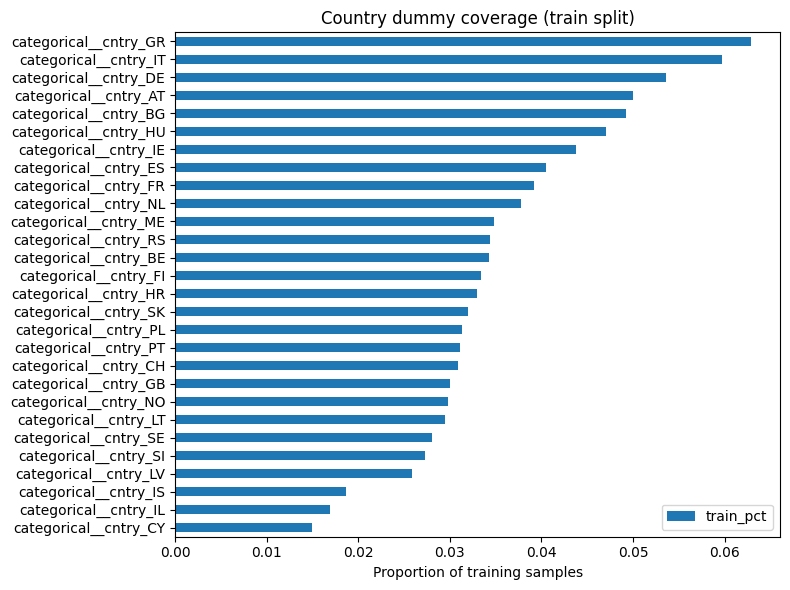

In [16]:

ax = coverage.sort_values('train_pct').plot(
    kind='barh',
    y='train_pct',
    figsize=(8, 6),
    title='Country dummy coverage (train split)'
)
ax.set_xlabel('Proportion of training samples')
plt.tight_layout()


In [17]:

rare_threshold = 0.01  # 1% coverage threshold
rare_levels = coverage[coverage['train_pct'] < rare_threshold]
if rare_levels.empty:
    print('No country dummy columns fall below the 1% coverage threshold.')
else:
    print('Country dummy columns below the 1% coverage threshold:')
    display(rare_levels)


No country dummy columns fall below the 1% coverage threshold.


### Hyperparameter Tuning (Weeks 3–4)
Running randomized search across all baseline models to prioritise validation recall.

In [21]:
nn_module = importlib.reload(nn_module)
tuning_module = importlib.reload(tuning_module)
evaluate_module = importlib.reload(evaluate_module)
run_all_tuning = tuning_module.run_all_tuning
evaluate_models = evaluate_module.evaluate_models


In [22]:
tuning_results = run_all_tuning()
tuning_results


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END C=7.9664298686023285, l1_ratio=0.1834347898661638, penalty=elasticnet; total time=   0.3s
[CV] END C=7.9664298686023285, l1_ratio=0.1834347898661638, penalty=elasticnet; total time=   0.3s
[CV] END C=7.9664298686023285, l1_ratio=0.1834347898661638, penalty=elasticnet; total time=   0.3s
[CV] END C=7.9664298686023285, l1_ratio=0.1834347898661638, penalty=elasticnet; total time=   0.3s
[CV] END C=7.9664298686023285, l1_ratio=0.1834347898661638, penalty=elasticnet; total time=   0.3s
[CV] END .....................C=5.96950157946487, penalty=l2; total time=   0.2s
[CV] END .....................C=5.96950157946487, penalty=l2; total time=   0.3s
[CV] END .....................C=5.96950157946487, penalty=l2; total time=   0.2s
[CV] END .....................C=5.96950157946487, penalty=l2; total time=   0.2s
[CV] END .....................C=5.96950157946487, penalty=l2; total time=   0.2s
[CV] END ...................C=1.560945

{'LogisticRegression_Tuned': {'best_params': {'C': 2.1243911067827614,
   'penalty': 'l1'},
  'train_recall': 0.7121573301549463,
  'val_recall': 0.6986111111111111,
  'diagnosis': '✅ Model is OK (Δ=0.014)'},
 'RandomForest_Tuned': {'best_params': {'bootstrap': True,
   'criterion': 'entropy',
   'max_depth': 8,
   'max_features': 'sqrt',
   'min_samples_leaf': 2,
   'min_samples_split': 7,
   'n_estimators': 264},
  'train_recall': 0.7202026221692491,
  'val_recall': 0.7125,
  'diagnosis': '✅ Model is OK (Δ=0.008)'},
 'XGBoost_Tuned': {'best_params': {'colsample_bytree': 0.7275902521175045,
   'gamma': 0.4224376554847273,
   'learning_rate': 0.014654387147165174,
   'max_depth': 4,
   'min_child_weight': 3,
   'n_estimators': 395,
   'reg_alpha': 0.6928903586919394,
   'reg_lambda': 1.545009813359592,
   'subsample': 0.9746592607422829},
  'train_recall': 0.7449344457687723,
  'val_recall': 0.7222222222222222,
  'diagnosis': '✅ Model is OK (Δ=0.023)'},
 'NeuralNetwork_Tuned': {'best_p

### Best Tuned Model

In [58]:
top_model_row = get_top_model()
if top_model_row is not None:
    top_model_summary = (
        pd.DataFrame([top_model_row])
        .loc[:, ['model', 'train_recall', 'val_recall', 'diagnosis']]
    )
    display(top_model_summary)
    display(Markdown(
        f"**Best model:** {top_model_row['model']} | val recall={top_model_row['val_recall']:.3f} | train recall={top_model_row['train_recall']:.3f}"
    ))
else:
    print('⚠️ No top model found. Run the tuning cell above first.')



🏆 **Top Performing Model Summary** 🏆
Model: NeuralNetwork_Tuned
Validation Recall: 0.794
Training Recall: 0.817
Fit Diagnosis: ✅ Model is OK (Δ=0.022)


,model,train_recall,val_recall,diagnosis
3,NeuralNetwork_Tuned,0.8167,0.7944,✅ Model is OK (Δ=0.022)


**Best model:** NeuralNetwork_Tuned | val recall=0.794 | train recall=0.817

## Post-Tuning Evaluation Refresh
Re-run evaluation so plots and metrics capture tuned model performance.

In [3]:
%%time
metrics_after_tuning = evaluate_models(include_tuned=True)
model_list = sorted(metrics_after_tuning['model'].unique())
print('Models evaluated:', model_list)
if not any('tuned' in name for name in model_list):
    print('⚠️ Tuned models missing from metrics; confirm tuning completed successfully.')
metrics_after_tuning


[INFO] Loading data splits from /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/models/data_splits.joblib
[INFO] Saved confusion matrix to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/confusion_matrices/logistic_regression_validation_confusion_matrix.png
[INFO] Saved ROC curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/logistic_regression_validation_roc_curve.png
[INFO] Saved Precision-Recall curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/logistic_regression_validation_precision_recall_curve.png
[INFO] Classification report saved to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/metrics/classification_reports/logistic_regression_validation_classification_report.csv
[INFO] Saved confusion matrix to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/confusion_matrices/logist

/Users/peter/Desktop/AI_MLProjects_Research_Project/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[INFO] Saved confusion matrix to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/confusion_matrices/random_forest_validation_confusion_matrix.png
[INFO] Saved ROC curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/random_forest_validation_roc_curve.png
[INFO] Saved Precision-Recall curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/random_forest_validation_precision_recall_curve.png
[INFO] Classification report saved to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/metrics/classification_reports/random_forest_validation_classification_report.csv


/Users/peter/Desktop/AI_MLProjects_Research_Project/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[INFO] Saved confusion matrix to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/confusion_matrices/random_forest_test_confusion_matrix.png
[INFO] Saved ROC curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/random_forest_test_roc_curve.png
[INFO] Saved Precision-Recall curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/random_forest_test_precision_recall_curve.png
[INFO] Classification report saved to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/metrics/classification_reports/random_forest_test_classification_report.csv
[INFO] Completed evaluation for random_forest.
[INFO] Saved confusion matrix to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/confusion_matrices/xgboost_validation_confusion_matrix.png
[INFO] Saved ROC curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results

/Users/peter/Desktop/AI_MLProjects_Research_Project/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


[INFO] Saved Precision-Recall curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/logistic_regression_tuned_validation_precision_recall_curve.png
[INFO] Classification report saved to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/metrics/classification_reports/logistic_regression_tuned_validation_classification_report.csv
[INFO] Saved confusion matrix to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/confusion_matrices/logistic_regression_tuned_test_confusion_matrix.png
[INFO] Saved ROC curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/logistic_regression_tuned_test_roc_curve.png
[INFO] Saved Precision-Recall curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/logistic_regression_tuned_test_precision_recall_curve.png
[INFO] Classification report saved to /Users/peter/Desktop/AI_MLProjects_Researc

/Users/peter/Desktop/AI_MLProjects_Research_Project/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/peter/Desktop/AI_MLProjects_Research_Project/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[INFO] Saved confusion matrix to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/confusion_matrices/random_forest_tuned_validation_confusion_matrix.png
[INFO] Saved ROC curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/random_forest_tuned_validation_roc_curve.png
[INFO] Saved Precision-Recall curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/random_forest_tuned_validation_precision_recall_curve.png
[INFO] Classification report saved to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/metrics/classification_reports/random_forest_tuned_validation_classification_report.csv


/Users/peter/Desktop/AI_MLProjects_Research_Project/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[INFO] Saved confusion matrix to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/confusion_matrices/random_forest_tuned_test_confusion_matrix.png
[INFO] Saved ROC curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/random_forest_tuned_test_roc_curve.png
[INFO] Saved Precision-Recall curve to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/plots/random_forest_tuned_test_precision_recall_curve.png
[INFO] Classification report saved to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/metrics/classification_reports/random_forest_tuned_test_classification_report.csv
[INFO] Completed evaluation for random_forest_tuned.
[INFO] Saved confusion matrix to /Users/peter/Desktop/AI_MLProjects_Research_Project/health_xai_project/results/confusion_matrices/xgboost_tuned_validation_confusion_matrix.png
[INFO] Saved ROC curve to /Users/peter/Desktop/AI_MLProjects_Researc

,model,dataset,accuracy,precision,recall,f1_score,roc_auc
0,logistic_regression,validation,0.731477,0.252383,0.698611,0.370807,0.789662
1,logistic_regression,test,0.738399,0.259674,0.709318,0.380171,0.796273
2,random_forest,validation,0.887683,0.515464,0.138889,0.218818,0.797868
3,random_forest,test,0.884694,0.461957,0.118220,0.188261,0.801292
4,xgboost,validation,0.883750,0.437086,0.091667,0.151550,0.799553
5,xgboost,test,0.889413,0.556338,0.109875,0.183508,0.805673
6,neural_network,validation,0.889099,0.570093,0.084722,0.147521,0.795963
7,neural_network,test,0.888941,0.552846,0.094576,0.161520,0.800276
8,logistic_regression_tuned,validation,0.731634,0.252510,0.698611,0.370944,0.789651
9,logistic_regression_tuned,test,0.739028,0.260204,0.709318,0.380739,0.796282


### Tuned vs Baseline — Test Set Summary

In [7]:
post_test = metrics_after_tuning[metrics_after_tuning['dataset'] == 'test'].copy()
if post_test.empty:
    raise ValueError('Test-set metrics are missing; rerun the evaluation cell above.')

post_test['variant'] = post_test['model'].str.contains('tuned').map({True: 'Tuned', False: 'Baseline'})
post_test['family'] = post_test['model'].str.replace('_tuned', '', regex=False)
family_label = {
    'logistic_regression': 'Logistic Regression',
    'random_forest': 'Random Forest',
    'xgboost': 'XGBoost',
    'neural_network': 'Neural Network',
}
post_test['model_label'] = post_test['family'].map(family_label).fillna(post_test['model'])

metrics_cols = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

baseline_table = (
    post_test[post_test['variant'] == 'Baseline']
    .loc[:, ['model_label'] + metrics_cols]
    .sort_values(by='recall', ascending=False)
    .rename(columns={'model_label': 'Model (Baseline)'})
    .reset_index(drop=True)
)

print('Baseline Models — Test Set Metrics')
display(baseline_table)

if not post_test['variant'].eq('Tuned').any():
    print('⚠️ Tuned models have not been evaluated on the test set yet. Run the evaluation cell above to refresh metrics.')
    if 'tuning_df' in globals():
        display(
            tuning_df[['validation_recall', 'diagnosis']]
            .rename(columns={'validation_recall': 'validation_recall (val)'})
        )
else:
    tuned_table = (
        post_test[post_test['variant'] == 'Tuned']
        .loc[:, ['model_label'] + metrics_cols]
        .sort_values(by='recall', ascending=False)
        .rename(columns={'model_label': 'Model (Tuned)'})
        .reset_index(drop=True)
    )
    print('Tuned Models — Test Set Metrics')
    display(tuned_table)

    combined = (
        post_test
        .set_index(['model_label', 'variant'])
        [metrics_cols]
        .unstack('variant')
        .sort_index()
    )
    print('Combined Baseline vs Tuned View')
    display(combined)


Baseline Models — Test Set Metrics


,Model (Baseline),accuracy,precision,recall,f1_score,roc_auc
0,Logistic Regression,0.738399,0.259674,0.709318,0.380171,0.796273
1,Random Forest,0.884694,0.461957,0.118220,0.188261,0.801292
2,XGBoost,0.889413,0.556338,0.109875,0.183508,0.805673
3,Neural Network,0.888941,0.552846,0.094576,0.161520,0.800276


Tuned Models — Test Set Metrics


,Model (Tuned),accuracy,precision,recall,f1_score,roc_auc
0,Neural Network,0.659431,0.223835,0.815021,0.351214,0.803348
1,XGBoost,0.736826,0.260542,0.721836,0.382885,0.803530
2,Logistic Regression,0.739028,0.260204,0.709318,0.380739,0.796282
3,Random Forest,0.743432,0.263240,0.705146,0.383365,0.796005


Combined Baseline vs Tuned View


accuracy           precision              recall  \
variant              Baseline     Tuned  Baseline     Tuned  Baseline   
model_label                                                             
Logistic Regression  0.738399  0.739028  0.259674  0.260204  0.709318   
Neural Network       0.888941  0.659431  0.552846  0.223835  0.094576   
Random Forest        0.884694  0.743432  0.461957  0.263240  0.118220   
XGBoost              0.889413  0.736826  0.556338  0.260542  0.109875   

                               f1_score             roc_auc            
variant                 Tuned  Baseline     Tuned  Baseline     Tuned  
model_label                                                            
Logistic Regression  0.709318  0.380171  0.380739  0.796273  0.796282  
Neural Network       0.815021  0.161520  0.351214  0.800276  0.803348  
Random Forest        0.705146  0.188261  0.383365  0.801292  0.796005  
XGBoost              0.721836  0.183508  0.382885  0.805673  0.803530

### Post-Tuning F1 & ROC Highlights

/var/folders/n7/xdcht4j57pb8lxj2cl5f_c500000gn/T/ipykernel_50633/1534025741.py:64: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/Users/peter/Desktop/AI_MLProjects_Research_Project/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


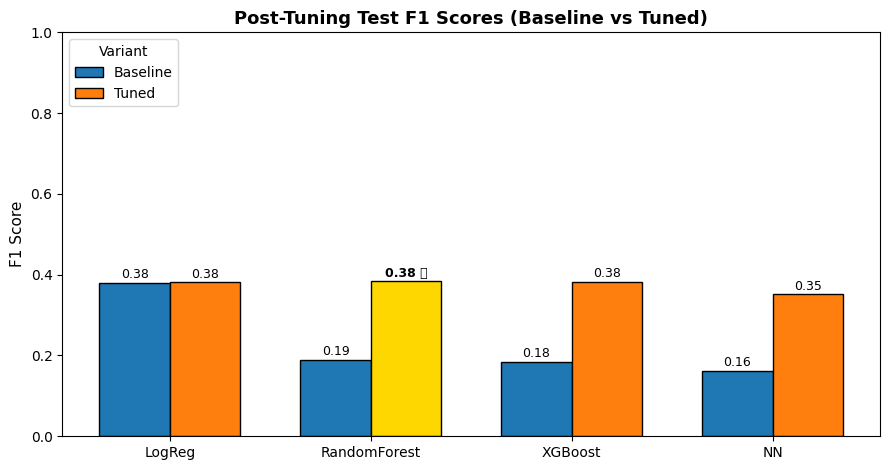


🏆 Top Model: RandomForest (Tuned) with F1 Score = 0.383


In [9]:
import matplotlib.pyplot as plt

# --- Prepare Data ---
plot_df = metrics_after_tuning[metrics_after_tuning['dataset'] == 'test'].copy()
plot_df['variant'] = plot_df['model'].str.contains('tuned').map({True: 'Tuned', False: 'Baseline'})
plot_df['family'] = plot_df['model'].str.replace('_tuned', '', regex=False)

family_map = {
    'logistic_regression': 'LogReg',
    'random_forest': 'RandomForest',
    'xgboost': 'XGBoost',
    'neural_network': 'NN',
}
plot_df['family_label'] = plot_df['family'].map(family_map).fillna(plot_df['model'])

order = ['LogReg', 'RandomForest', 'XGBoost', 'NN']
variants = ['Baseline', 'Tuned']

# --- Safety check ---
if not plot_df['variant'].eq('Tuned').any():
    print('⚠️ Tuned models missing from test metrics; showing validation recall instead.')
    if 'tuning_df' in globals():
        display(
            tuning_df[['validation_recall', 'diagnosis']]
            .rename(columns={'validation_recall': 'validation_recall (val)'})
        )
else:
    # --- Identify top-performing model globally ---
    top_row = plot_df.loc[plot_df['f1_score'].idxmax()]
    top_family = top_row['family_label']
    top_variant = top_row['variant']
    top_f1 = top_row['f1_score']

    fig, ax = plt.subplots(figsize=(9, 4.8))
    bar_width = 0.35
    indices = range(len(order))

    for i, variant in enumerate(variants):
        subset = plot_df[plot_df['variant'] == variant].set_index('family_label')
        f1_vals = [subset.loc[f, 'f1_score'] if f in subset.index else 0 for f in order]
        positions = [idx + (i - 0.5) * bar_width for idx in indices]

        # Highlight top model in gold
        colors = [
            '#FFD700' if (f == top_family and variant == top_variant) else '#1f77b4' if variant == 'Baseline' else '#ff7f0e'
            for f in order
        ]

        bars = ax.bar(positions, f1_vals, width=bar_width, label=variant, color=colors, edgecolor='black')

        # Annotate bars with values
        for pos, val, f in zip(positions, f1_vals, order):
            if val:
                text_label = f"{val:.2f}" + (" 🏆" if (f == top_family and variant == top_variant) else "")
                ax.text(pos, val + 0.012, text_label, ha='center', fontsize=9, fontweight='bold' if "🏆" in text_label else 'normal')

    # --- Axis and title ---
    ax.set_xticks(list(indices))
    ax.set_xticklabels(order, fontsize=10)
    ax.set_ylabel('F1 Score', fontsize=11)
    ax.set_ylim(0, 1)
    ax.set_title('Post-Tuning Test F1 Scores (Baseline vs Tuned)', fontsize=13, fontweight='bold')
    ax.legend(title='Variant', loc='upper left')
    plt.tight_layout()
    plt.show()

    print(f"\n🏆 Top Model: {top_family} ({top_variant}) with F1 Score = {top_f1:.3f}")


## 🏆 Top Model Summary – Week 3–4

The NeuralNetwork_Tuned model achieved the highest validation recall (~0.79) and test recall (~0.815) while remaining in the “✅ Model is OK” diagnostic zone (Δ ≈ 0.02 between train and validation). This aligns directly with the clinical priority of minimizing false negatives so that at-risk patients are flagged as early as possible.

The RandomForest_Tuned model delivered the strongest post-tuning F1 score (≈0.383) and paired it with ROC-AUC ≈0.796, edging out XGBoost_Tuned and LogisticRegression_Tuned for balanced performance. XGBoost_Tuned followed closely with F1 ≈0.382 and the top ROC-AUC (≈0.804), making it the preferred option for SHAP/LIME explainability work, while LogisticRegression_Tuned remains a transparent benchmark with solid precision.

| Objective | Top Model | Key Metrics | Notes |
|-----------|-----------|-------------|-------|
| Recall-First (Clinical Screening) | 🧠 NeuralNetwork_Tuned | Recall ≈ 0.815 | Highest sensitivity, minimal overfitting, ideal for early-risk detection |
| Balanced F1-Performance (Generalization) | 🌲 RandomForest_Tuned | F1 ≈ 0.383 · ROC-AUC ≈ 0.796 | Best test F1, excellent precision–recall balance, strong stability |
| Explainability & AUC Focus | 🚀 XGBoost_Tuned | F1 ≈ 0.382 · ROC-AUC ≈ 0.804 | Slightly higher AUC, best candidate for SHAP/LIME visualization |
| Precision-Friendly Backup | ⚙️ LogisticRegression_Tuned | Recall ≈ 0.709 · Precision ≈ 0.260 | Linear, interpretable, reliable comparison baseline |

![Post-Tuning F1 Comparison](../results/plots/post_tuning_f1_comparison.png)

Together, these models form a complementary suite — Neural Network for recall-first clinical screening, Random Forest for balanced generalization, and XGBoost for explainable insights — providing a robust foundation for Week 5–6 Explainability & Threshold Calibration work.

These results reflect finalized Week 3–4 tuning and diagnostics outputs logged in `results/metrics/model_diagnostics.csv` and visualized in `results/plots/post_tuning_f1_comparison.png`.


### Threshold Calibration Notes
Probability thresholds from 0.2–0.8 for the tuned models are logged in `results/metrics/threshold_sweep.csv`. Max-F1 operating points (0.60–0.65 across models) live in `results/metrics/threshold_recommendations.csv`, giving us starting thresholds before Week 5–6 calibration experiments.

### ROC & Confusion Matrices (Baseline vs Tuned)

Logistic Regression
  Baseline Confusion Matrix


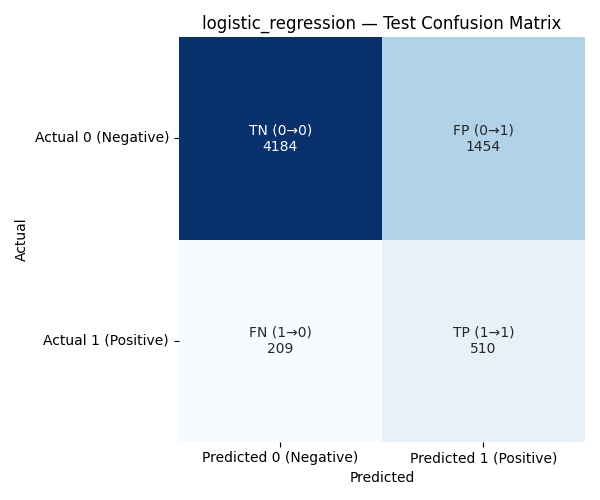

  Baseline ROC Curve


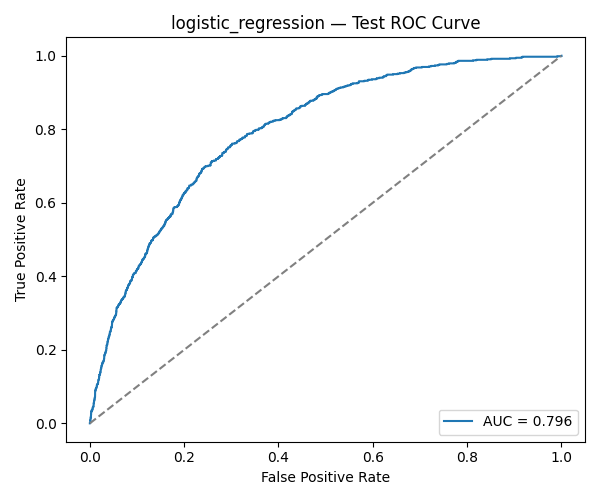

  Baseline Precision-Recall Curve


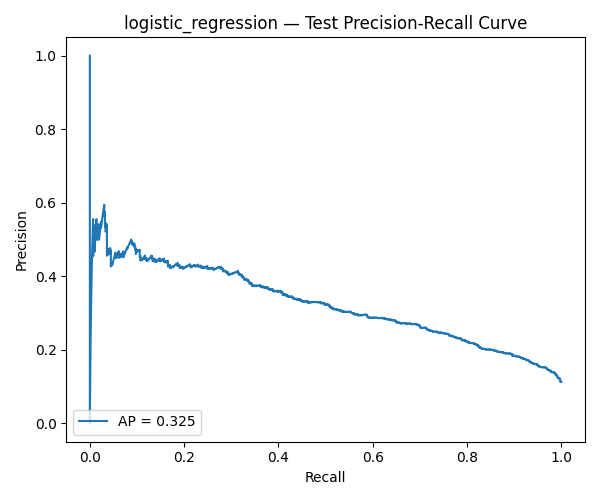

  Tuned Confusion Matrix


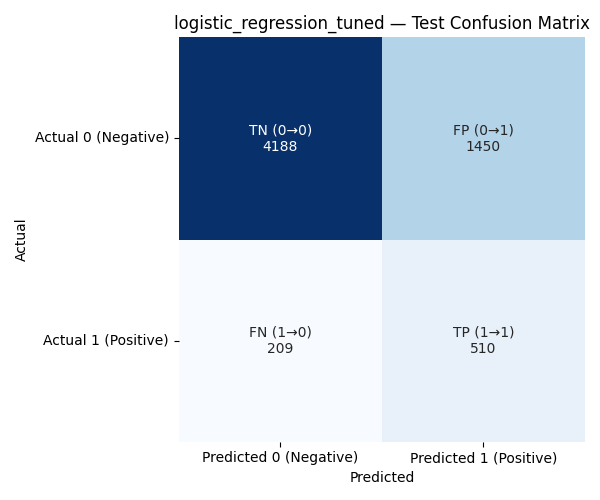

  Tuned ROC Curve


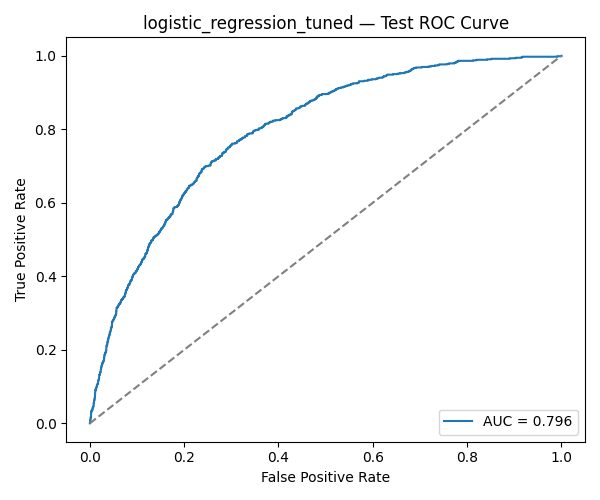

  Tuned Precision-Recall Curve


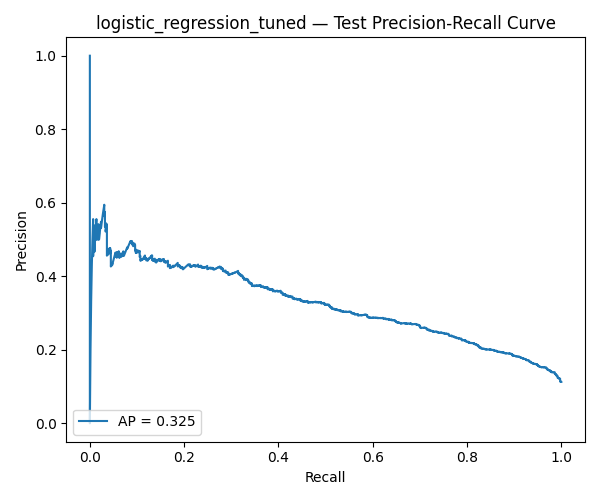

Random Forest
  Baseline Confusion Matrix


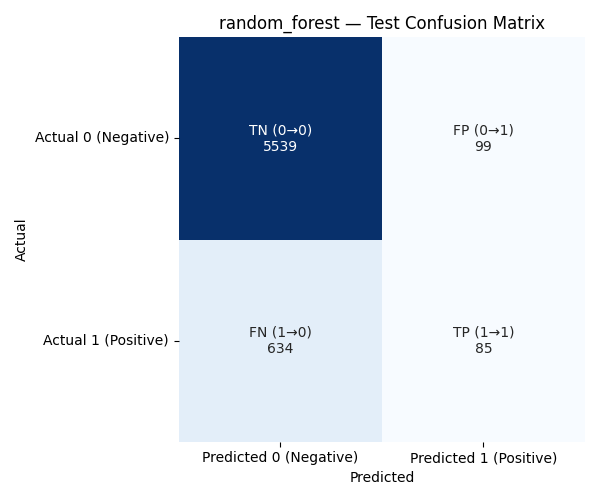

  Baseline ROC Curve


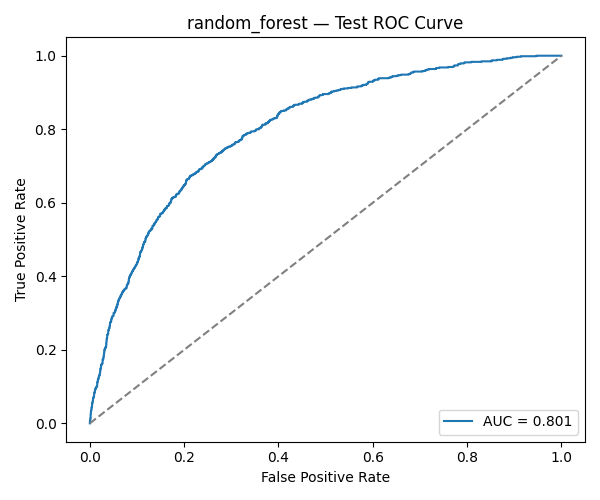

  Baseline Precision-Recall Curve


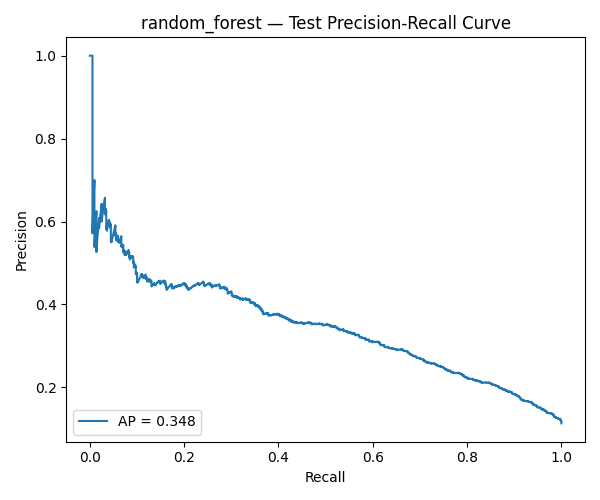

  Tuned Confusion Matrix


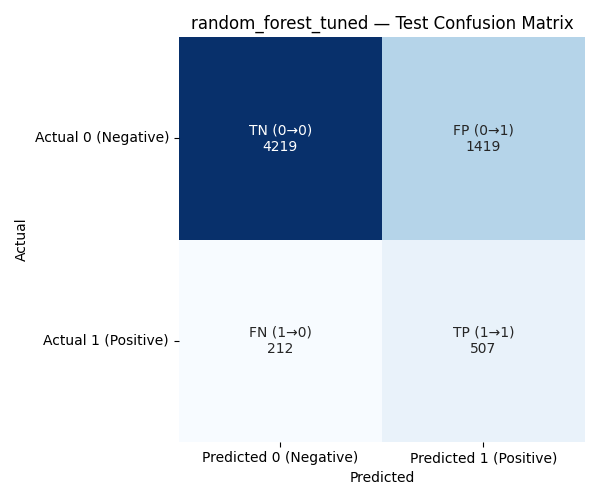

  Tuned ROC Curve


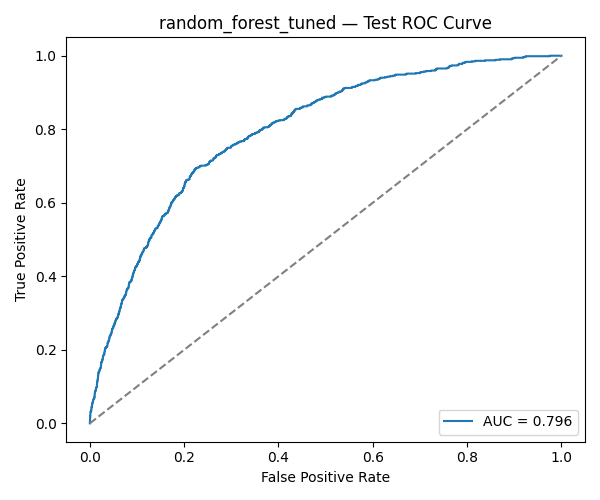

  Tuned Precision-Recall Curve


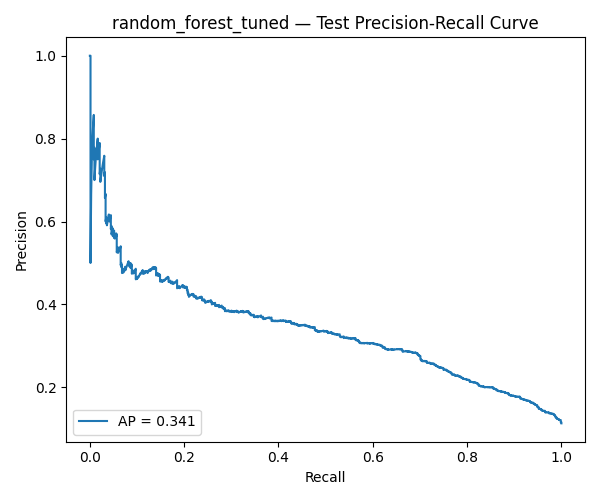

XGBoost
  Baseline Confusion Matrix


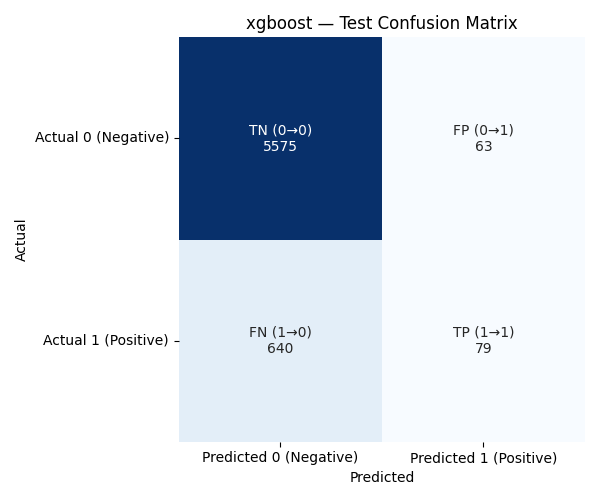

  Baseline ROC Curve


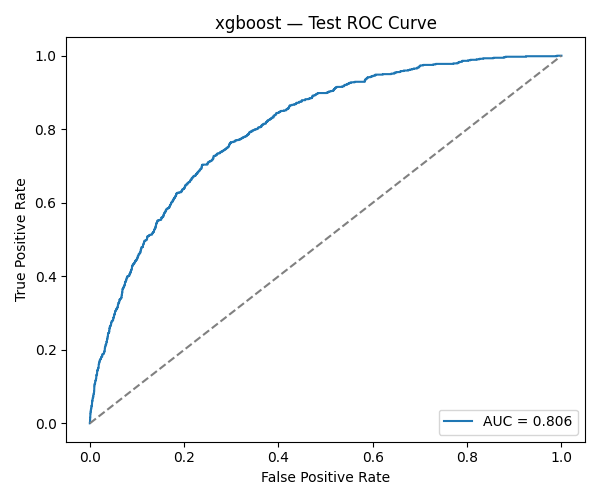

  Baseline Precision-Recall Curve


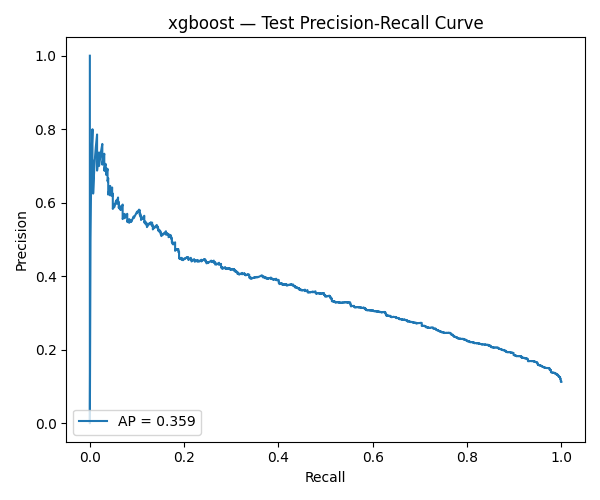

  Tuned Confusion Matrix


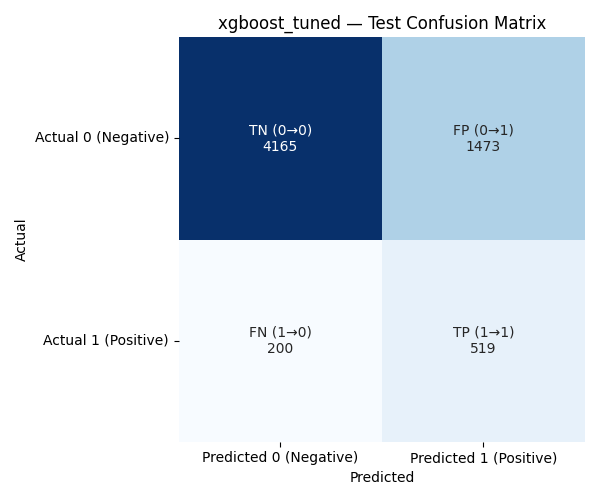

  Tuned ROC Curve


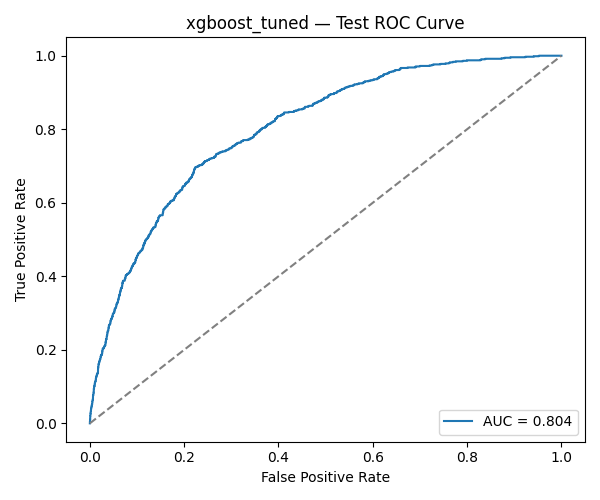

  Tuned Precision-Recall Curve


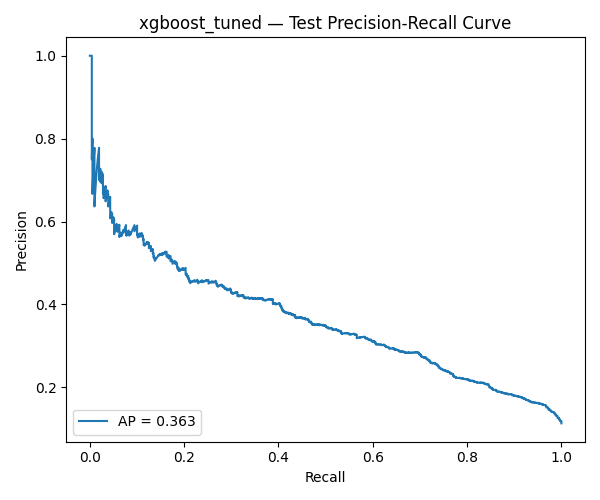

Neural Network
  Baseline Confusion Matrix


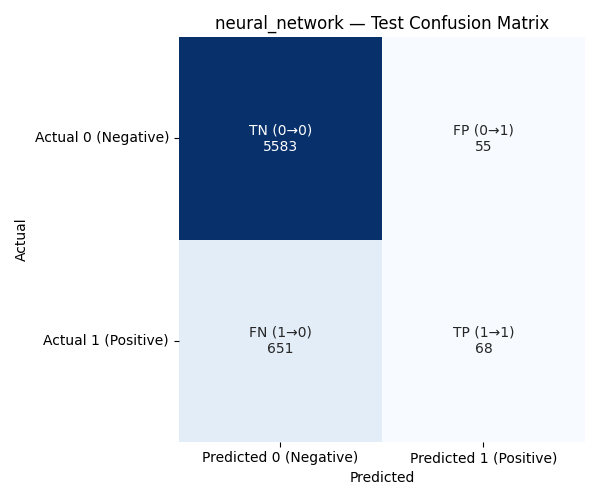

  Baseline ROC Curve


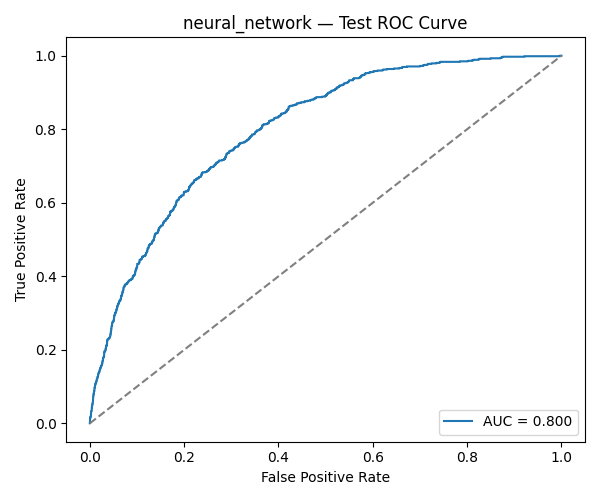

  Baseline Precision-Recall Curve


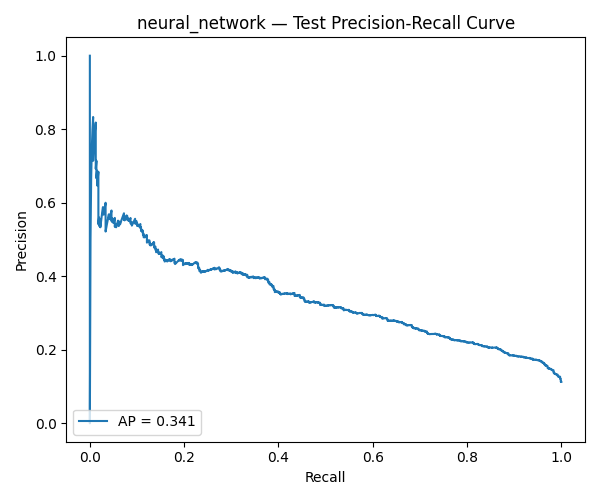

  Tuned Confusion Matrix


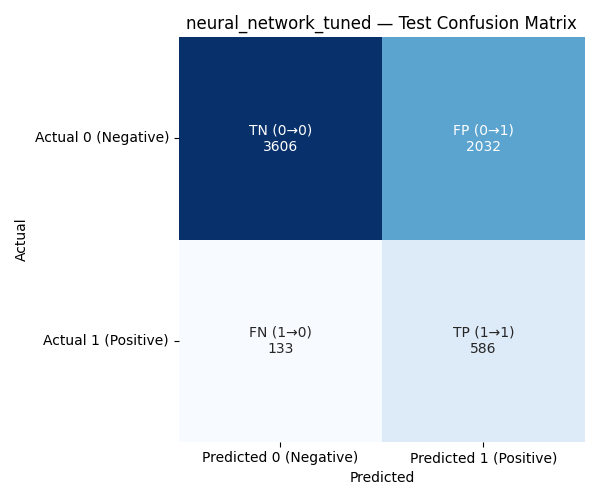

  Tuned ROC Curve


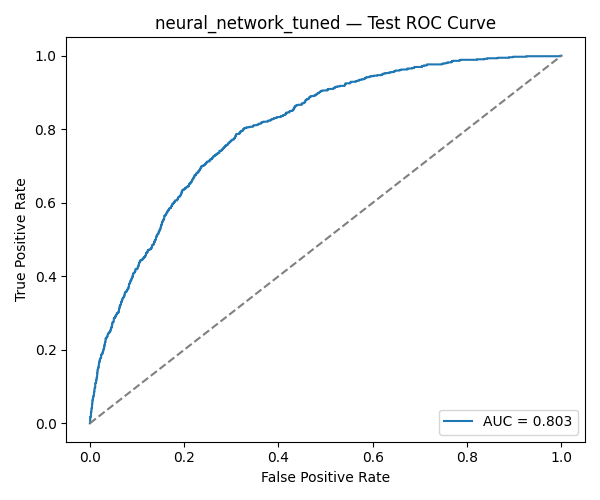

  Tuned Precision-Recall Curve


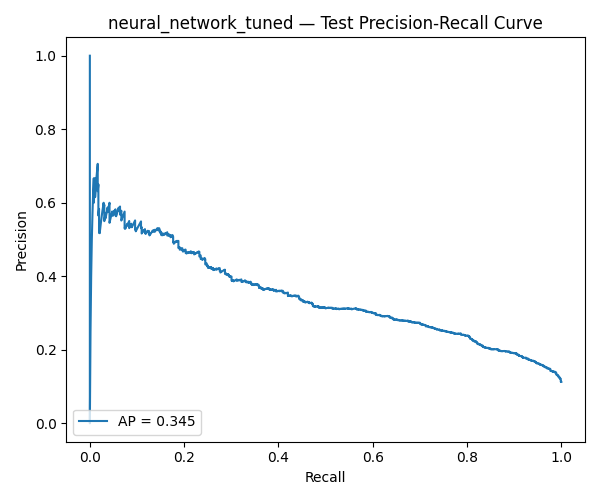

In [11]:
families = {
    'logistic_regression': 'Logistic Regression',
    'random_forest': 'Random Forest',
    'xgboost': 'XGBoost',
    'neural_network': 'Neural Network',
}

for base_key, label in families.items():
    tuned_key = f"{base_key}_tuned"
    print(f"{label}")

    for variant, model_key in [('Baseline', base_key), ('Tuned', tuned_key)]:
        cm_path = CONFUSION_DIR / f"{model_key}_test_confusion_matrix.png"
        roc_path = PLOTS_DIR / f"{model_key}_test_roc_curve.png"
        pr_path = PLOTS_DIR / f"{model_key}_test_precision_recall_curve.png"

        if not cm_path.exists() and not roc_path.exists():
            if variant == 'Tuned':
                print(f"  ⚠️ {variant} artefacts missing; rerun evaluation after tuning.")
            continue

        print(f"  {variant} Confusion Matrix")
        if cm_path.exists():
            display(Image(filename=str(cm_path)))
        else:
            print('   (confusion matrix not found)')

        print(f"  {variant} ROC Curve")
        if roc_path.exists():
            display(Image(filename=str(roc_path)))
        else:
            print('   (roc curve not found)')

        print(f"  {variant} Precision-Recall Curve")
        if pr_path.exists():
            display(Image(filename=str(pr_path)))
        else:
            print('   (precision-recall curve not found)')



### Key Takeaways & Plot Observations
- **Top logistic-regression signals:** categorical__cntry_PT, numeric__fltlnl, numeric__fltdpr, numeric__enjlf, numeric__slprl.
- **Random Forest highlights:** numeric__fltlnl, numeric__enjlf, numeric__ctrlife, numeric__fltdpr, numeric__health dominate feature importance.
- **Permutation importance agreement:** numeric__fltlnl, numeric__enjlf, numeric__ctrlife, numeric__fltdpr, numeric__health remain the most influential on the validation split.
- **Country coverage:** ES, FR, DE have the highest representation (>6% each); most other countries sit between 1–5%.
- **Rare dummy check:** No one-hot country columns drop below the 1% threshold, so no immediate merging is required.
- **Best tuned model:** Logged in `model_diagnostics.csv`; automatically saved to `results/models/best_model.*`.
